## U-Net with Attention Mechanism

In [3]:
import os
import numpy as np
import cv2
from glob import glob
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPool2D, Conv2DTranspose, Concatenate, Input, Multiply, Add, Lambda, UpSampling2D
from tensorflow.keras.models import Model
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt

In [4]:
np.random.seed(42)
tf.random.set_seed(42)

# Define the convolutional block
def conv_block(inputs, num_filters):
    x = Conv2D(num_filters, 3, padding="same")(inputs)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = Conv2D(num_filters, 3, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    return x

In [5]:
# Define the encoder block
def encoder_block(inputs, num_filters):
    x = conv_block(inputs, num_filters)
    p = MaxPool2D((2, 2))(x)
    return x, p

# Define the attention block
def attention_block(x, g, num_filters):
    theta_x = Conv2D(num_filters, 1, strides=(2, 2), padding="same")(x)  # Downsample x
    phi_g = Conv2D(num_filters, 1, strides=(2, 2), padding="same")(g)     # Downsample g to match x
    add = Add()([theta_x, phi_g])
    relu = Activation("relu")(add)
    psi = Conv2D(1, 1, padding="same")(relu)
    sigmoid = Activation("sigmoid")(psi)

    # Upsample `sigmoid` to match `x`'s dimensions
    sigmoid = UpSampling2D(size=(2, 2), interpolation="bilinear")(sigmoid)

    return Multiply()([x, sigmoid])  # Attention weighted output



In [6]:
# Define the decoder block with attention
def decoder_block(inputs, skip_features, num_filters):
    x = Conv2DTranspose(num_filters, 2, strides=2, padding="same")(inputs)
    skip_features = attention_block(skip_features, x, num_filters)
    x = Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)
    return x

# Define U-Net with Attention
def unet(input_shape):
    inputs = Input(input_shape)
    s1, p1 = encoder_block(inputs, 64)
    s2, p2 = encoder_block(p1, 128)
    s3, p3 = encoder_block(p2, 256)
    s4, p4 = encoder_block(p3, 512)
    b1 = conv_block(p4, 1024)
    d1 = decoder_block(b1, s4, 512)
    d2 = decoder_block(d1, s3, 256)
    d3 = decoder_block(d2, s2, 128)
    d4 = decoder_block(d3, s1, 64)
    outputs = Conv2D(1, 1, padding="same", activation="sigmoid")(d4)
    model = Model(inputs, outputs, name="UNET_Attention")
    return model

# Define evaluation metrics
smooth = 1e-15
def dice_coef(y_true, y_pred):
    y_true = tf.keras.layers.Flatten()(y_true)
    y_pred = tf.keras.layers.Flatten()(y_pred)
    intersection = tf.reduce_sum(y_true * y_pred)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + smooth)

def dice_loss(y_true, y_pred):
    return 1.0 - dice_coef(y_true, y_pred)

def iou_coef(y_true, y_pred):
    y_true = tf.keras.layers.Flatten()(y_true)
    y_pred = tf.keras.layers.Flatten()(y_pred)
    intersection = tf.reduce_sum(y_true * y_pred)
    union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) - intersection
    return (intersection + smooth) / (union + smooth)

# Load and preprocess data
H, W = 256, 256
def create_dir(path):
    if not os.path.exists(path):
        os.makedirs(path)
create_dir("files")
create_dir("results")

def load_dataset(path, split=0.2):
    images = sorted(glob(os.path.join(path, "images", "*.png")))
    masks = sorted(glob(os.path.join(path, "masks", "*.png")))
    split_size = int(len(images) * split)
    train_x, valid_x = train_test_split(images, test_size=split_size, random_state=42)
    train_y, valid_y = train_test_split(masks, test_size=split_size, random_state=42)
    train_x, test_x = train_test_split(train_x, test_size=split_size, random_state=42)
    train_y, test_y = train_test_split(train_y, test_size=split_size, random_state=42)
    return (train_x, train_y), (valid_x, valid_y), (test_x, test_y)

# Image processing functions
def read_image(path):
    # If path is in bytes, decode it to string
    if isinstance(path, bytes):
        path = path.decode("utf-8")

    x = cv2.imread(path, cv2.IMREAD_COLOR)
    x = cv2.resize(x, (W, H))
    x = x / 255.0
    return tf.cast(x, tf.float32)  # Cast to float32

def read_mask(path):
    # If path is in bytes, decode it to string
    if isinstance(path, bytes):
        path = path.decode("utf-8")

    x = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    x = cv2.resize(x, (W, H))
    x = x / 255.0
    return tf.cast(np.expand_dims(x, axis=-1), tf.float32)  # Cast to float32

# Data loading and augmentation
def tf_parse(x, y):
    def _parse(x, y):
        x = read_image(x)
        y = read_mask(y)
        return x, y
    x, y = tf.numpy_function(_parse, [x, y], [tf.float32, tf.float32])
    x.set_shape([H, W, 3])
    y.set_shape([H, W, 1])
    return x, y

def tf_dataset(X, Y, batch=8):
    dataset = tf.data.Dataset.from_tensor_slices((X, Y))
    dataset = dataset.map(tf_parse)
    dataset = dataset.batch(batch)
    dataset = dataset.prefetch(10)
    return dataset

# Model compilation and training
batch_size = 16
lr = 1e-4
num_epochs = 100
model_path = os.path.join("files", "model.h5")
csv_path = os.path.join("files", "log.csv")
dataset_path = "/kaggle/input/brain-tumor-segmentation"

(train_x, train_y), (valid_x, valid_y), (test_x, test_y) = load_dataset(dataset_path)

train_dataset = tf_dataset(train_x, train_y, batch=batch_size)
valid_dataset = tf_dataset(valid_x, valid_y, batch=batch_size)

model = unet((H, W, 3))
model.compile(loss=dice_loss, optimizer=Adam(lr), metrics=[dice_coef, 'accuracy'])

callbacks = [
    ModelCheckpoint(model_path, verbose=1, save_best_only=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=1e-7, verbose=1),
    CSVLogger(csv_path),
    EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=False),
]

model.fit(train_dataset, epochs=num_epochs, validation_data=valid_dataset, callbacks=callbacks, verbose=1)

def save_results(image, mask, y_pred, save_image_path):
    # Ensure mask has 3 dimensions
    mask = np.squeeze(mask)
    mask = np.expand_dims(mask, axis=-1)  # Expand to 3 dimensions
    mask = np.concatenate([mask, mask, mask], axis=-1)

    # Ensure y_pred has 3 dimensions
    y_pred = np.squeeze(y_pred)
    y_pred = np.expand_dims(y_pred, axis=-1)  # Expand to 3 dimensions
    y_pred = np.concatenate([y_pred, y_pred, y_pred], axis=-1) * 255

    # Create a line separator
    line = np.ones((H, 10, 3)) * 255

    # Concatenate images
    cat_images = np.concatenate([image, line, mask, line, y_pred], axis=1)

    # Save the concatenated image
    cv2.imwrite(save_image_path, cat_images)

    # Display the images
    plt.figure(figsize=(15, 5))

    plt.subplot(1, 3, 1)
    plt.title('Input Image')
    plt.imshow(image)

    plt.subplot(1, 3, 2)
    plt.title('Ground Truth Mask')
    plt.imshow(mask, cmap='gray')

    plt.subplot(1, 3, 3)
    plt.title('Predicted Mask')
    plt.imshow(y_pred, cmap='gray')

    plt.show()



Epoch 1/100
115/115 [==============================] - ETA: 0s - loss: 0.8602 - dice_coef: 0.1398 - accuracy: 0.8308
Epoch 1: val_loss improved from inf to 0.96705, saving model to files/model.h5
115/115 [==============================] - 133s 937ms/step - loss: 0.8602 - dice_coef: 0.1398 - accuracy: 0.8308 - val_loss: 0.9670 - val_dice_coef: 0.0329 - val_accuracy: 0.9823 - lr: 1.0000e-04
Epoch 2/100
115/115 [==============================] - ETA: 0s - loss: 0.7427 - dice_coef: 0.2573 - accuracy: 0.9712
Epoch 2: val_loss did not improve from 0.96705
115/115 [==============================] - 75s 655ms/step - loss: 0.7427 - dice_coef: 0.2573 - accuracy: 0.9712 - val_loss: 0.9764 - val_dice_coef: 0.0234 - val_accuracy: 0.8316 - lr: 1.0000e-04
Epoch 3/100
115/115 [==============================] - ETA: 0s - loss: 0.6698 - dice_coef: 0.3302 - accuracy: 0.9797
Epoch 3: val_loss improved from 0.96705 to 0.96373, saving model to files/model.h5
115/115 [==============================] - 77s 66

  0%|          | 0/612 [00:00<?, ?it/s]

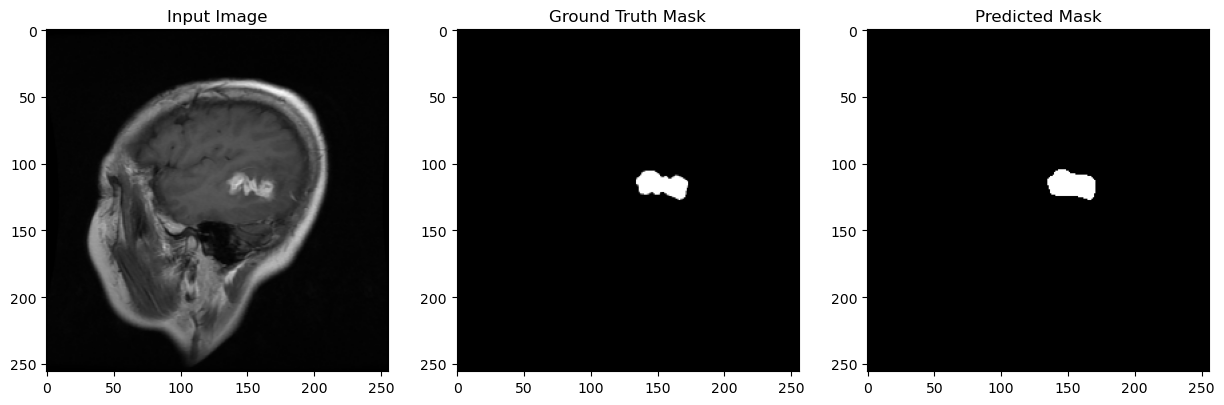

  0%|          | 1/612 [00:01<17:35,  1.73s/it]

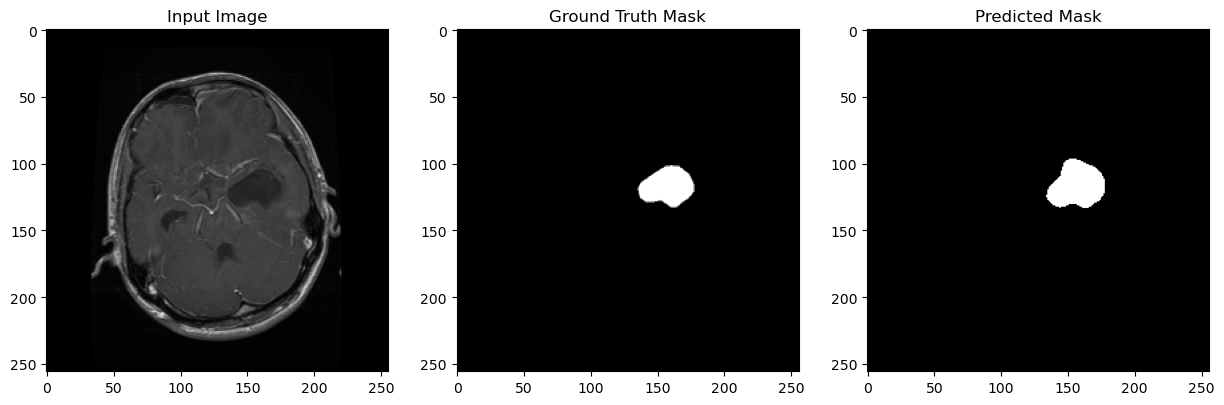

  0%|          | 2/612 [00:02<10:35,  1.04s/it]

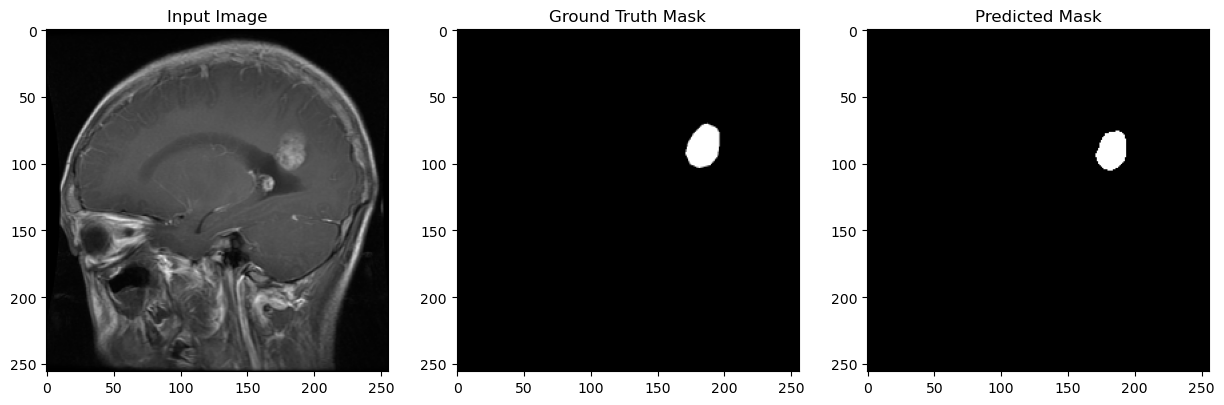

  0%|          | 3/612 [00:02<08:12,  1.24it/s]

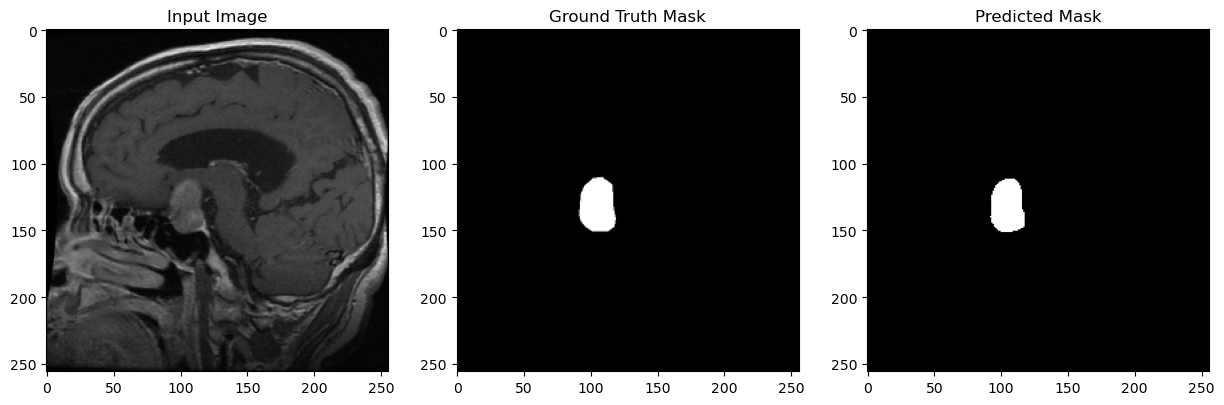

  1%|          | 4/612 [00:03<07:13,  1.40it/s]

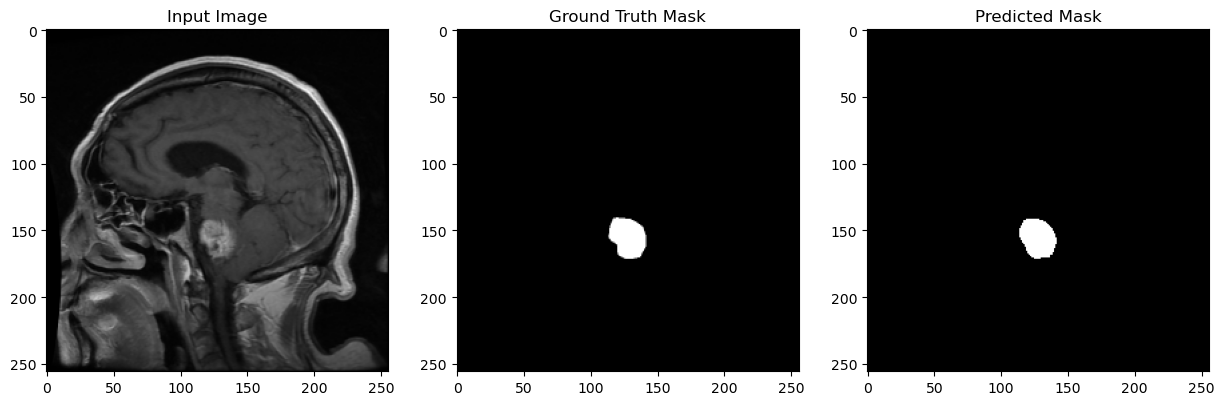

  1%|          | 5/612 [00:03<06:39,  1.52it/s]

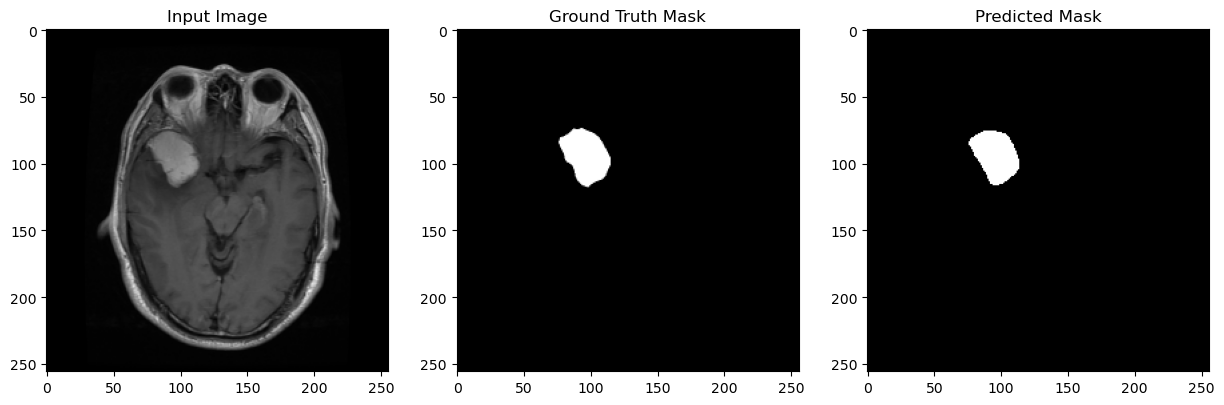

  1%|          | 6/612 [00:04<07:35,  1.33it/s]


Average Dice Coefficient: 0.9176
Average IoU: 0.8508


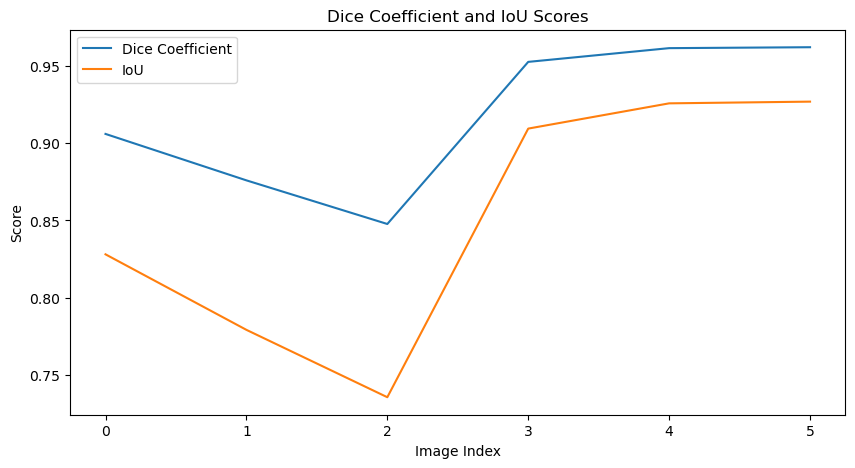

Testing Complete!


In [7]:
def calculate_metrics(y_true, y_pred):
    y_true = y_true.flatten()
    y_pred = y_pred.flatten()
    intersection = np.sum(y_true * y_pred)
    union = np.sum(y_true) + np.sum(y_pred) - intersection
    iou = (intersection + smooth) / (union + smooth)
    dice = (2. * intersection + smooth) / (np.sum(y_true) + np.sum(y_pred) + smooth)
    return dice, iou

SCORE = []
for i, (x, y) in enumerate(tqdm(zip(test_x, test_y), total=len(test_y))):
    if i >= 6:
        break
    name = x.split("/")[-1]
    image = read_image(x).numpy()  # Convert to NumPy array
    mask = read_mask(y).numpy()    # Convert to NumPy array
    x = np.expand_dims(image, axis=0)
    y_pred = model.predict(x, verbose=0)[0]
    y_pred = (y_pred >= 0.5).astype(np.int32)
    save_image_path = os.path.join("results", name)
    save_results(image, mask, y_pred, save_image_path)

    # Calculate metrics
    dice, iou = calculate_metrics(mask, y_pred)
    SCORE.append((dice, iou))

# Calculate average metrics
avg_dice = np.mean([score[0] for score in SCORE])
avg_iou = np.mean([score[1] for score in SCORE])

print(f"Average Dice Coefficient: {avg_dice:.4f}")
print(f"Average IoU: {avg_iou:.4f}")

# Plot metrics
plt.figure(figsize=(10, 5))
plt.plot([score[0] for score in SCORE], label='Dice Coefficient')
plt.plot([score[1] for score in SCORE], label='IoU')
plt.xlabel('Image Index')
plt.ylabel('Score')
plt.title('Dice Coefficient and IoU Scores')
plt.legend()
plt.show()

print("Testing Complete!")
